# Edge Detection
This notebook demonstrates filtering of images with the Sobel, Prewitt Gaussian and Laplacian kernels to perform basic edge Detection.

The OpenCV implementation for the Sobel filter is used. This contains a parameter that allows the kernel size to be adjusted. For the Prewitt and Laplacian kernels fixed size (finite difference) approximations are used. The sigma of the Gaussian kernel can be varied and the kernel size is automatically adjusted as detailed in lesson 1.    

Different images can be tried out with the various filters by changing the url in the section below.

You should be able to observe key principles of the filters.

*   x-direction kernels filter vertical features
*   y-direction kernels filter horizontal features
*   Rising and Falling edges visible in normalised images
*   Characteristic black and white lines around edges in Laplacian filtered image.

An example of the OpenCV implementation Canny edge detector is included also. It should be noted that the additional steps in the Canny detector (smoothing, Non-maximum supression and Hystersis Threholding) removes minor edges and a more defined boundary.     

**Housekeeping**:
Import packages, read test image, define helper functions.

In [8]:
import numpy as np
from skimage import feature
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import urllib.request


In [9]:
# function to read images from Web addresses.
def url_to_image(url):
	user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
	headers ={'User-Agent':user_agent,}
	request=urllib.request.Request(url,None,headers)
	resp = urllib.request.urlopen(request)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB
	return temp_image

In [12]:
def plot_img(ip_img,filter_name):
   f, axarr = plt.subplots(2,2,figsize=(10,8))
   axarr[0,0].imshow(ip_img[0],'gray')
   axarr[0,0].title.set_text('Greyscale Image')
   axarr[0,0].axis('off')
   axarr[0,1].imshow((ip_img[3]),'gray')
   axarr[0,1].title.set_text(filter_name+' Magnitude')
   axarr[0,1].axis('off')
   axarr[1,0].imshow((ip_img[1]+np.min(ip_img[1])),'gray')
   axarr[1,0].title.set_text(filter_name+' x-direction')
   axarr[1,0].axis('off')
   axarr[1,1].imshow(ip_img[2]+np.min(ip_img[2]),'gray')
   axarr[1,1].title.set_text(filter_name+' y-direction')
   axarr[1,1].axis('off')

def plot_img2(ip_imgs,labels):
   f, axarr = plt.subplots(1,3,figsize=(15,11))
   axarr[0].imshow(ip_imgs[0],'gray')
   axarr[0].title.set_text('Greyscale Image')
   axarr[0].axis('off')
   axarr[1].imshow((ip_imgs[2]),'gray')
   axarr[1].title.set_text(labels[0])
   axarr[1].axis('off')
   axarr[2].imshow((ip_imgs[1]),'gray')
   axarr[2].title.set_text(labels[1])
   axarr[2].axis('off')

def norm_img(ip_img):
   norm_img = ip_img-np.min(ip_img)
   norm_img = norm_img/(np.max(ip_img)-np.min(ip_img))
   return norm_img

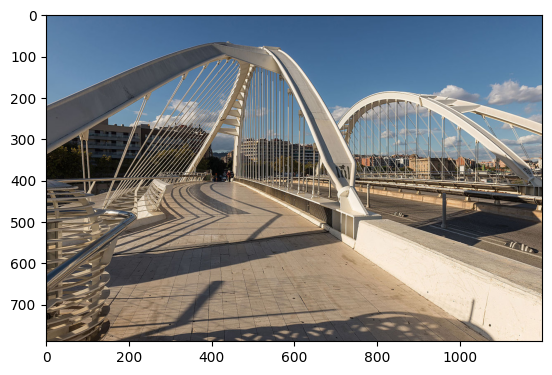

In [13]:
# read in test image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/8e/15-10-28-Pont_Bac_de_Roda_Barcelona-RalfR-WMA_3105.jpg/1200px-15-10-28-Pont_Bac_de_Roda_Barcelona-RalfR-WMA_3105.jpg"
image = url_to_image(image_url)
plt.imshow(image)
# Convert to greyscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Sobel Kernel:
The OpenCv implementation of the Sobel Kernel generates the sobel kernels and convolves this with the input grayscale image.

In [14]:
def sobel_filter(gray):
   sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=3)  # x kernel
   sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=3)  # y kernel
   sobel_mag = np.sqrt(sobelx**2+sobely**2)
   sobel_mag = sobel_mag/np.max(sobel_mag)
   return [gray,sobelx,sobely,sobel_mag]

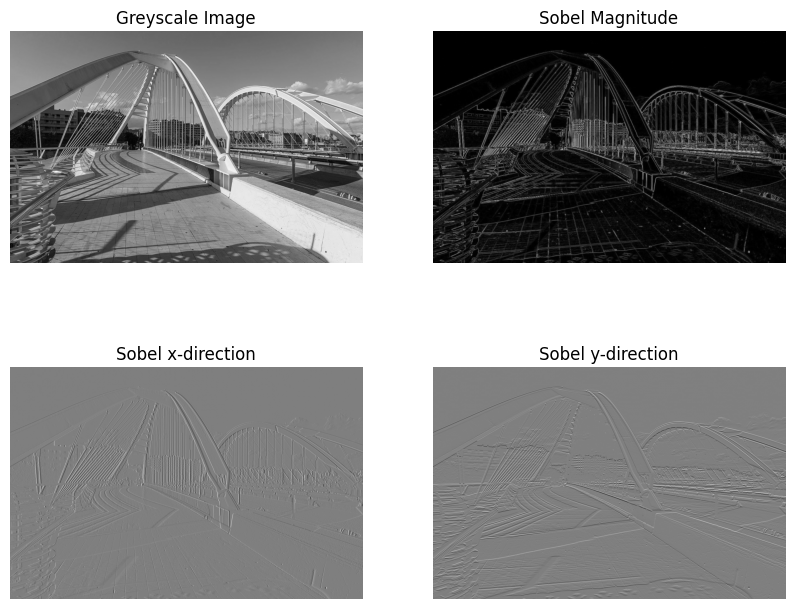

In [16]:
filter_name = 'Sobel'
ip_imgs = sobel_filter(gray)
plot_img(ip_imgs,filter_name)

#Prewitt Kernel
An finite difference approximation to the 1st order derivative is used. The convolve2d method from Scipy signal package (https://docs.scipy.org/doc/scipy/reference/signal.html) is used to convolve the input image with a 2D kernel.

In [17]:
def prewitt_filter(gray):
   kernelx = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
   kernely = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
   prewittx = signal.convolve2d(gray, kernelx, boundary='symm', mode='same').astype(np.float32)
   prewitty = signal.convolve2d(gray, kernely, boundary='symm', mode='same').astype(np.float32)
   norm_prewittx = norm_img(prewittx)
   norm_prewitty = norm_img(prewitty)
   prewitt_mag = np.sqrt(prewittx**2+prewitty**2)
   prewitt_mag = norm_img(prewitt_mag)
   return [gray,norm_prewittx,norm_prewitty,prewitt_mag]

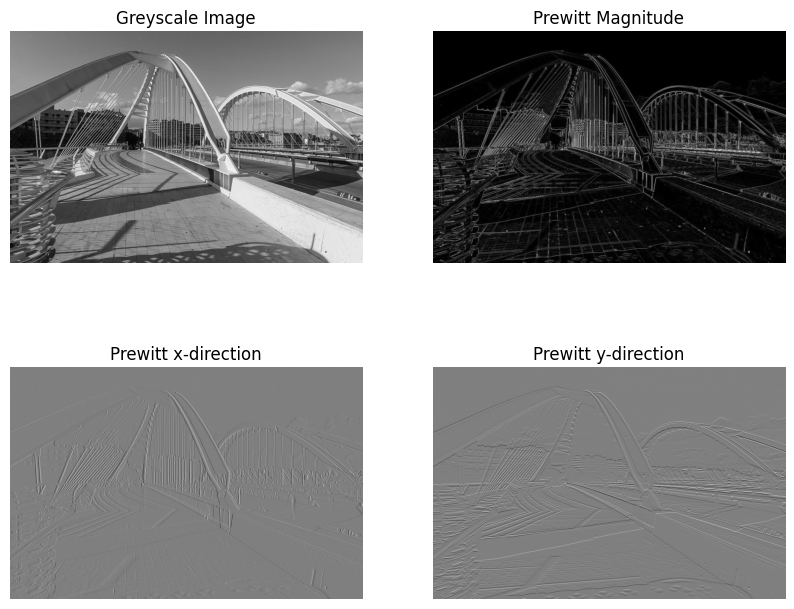

In [18]:
filter_name = 'Prewitt'
ip_imgs = prewitt_filter(gray)
plot_img(ip_imgs,filter_name)

#Derivative Gaussian kernel
The gaussian derivative kernel is formed from the outer product of 1d gaussian and gaussian derivative kernels. The value of sigma can be adjusted to increase the amount of smoothing.


In [19]:
def gauss_kernel(sigma):
   k_size = int(6*sigma+1)
   rng = (k_size-1)//2
   x = np.arange(-rng,rng+1)
   gauss_derv_kernel = (-np.exp((-x**2)/(2*sigma**2))*x)/(np.sqrt(2*np.pi)*(sigma**3))
   gauss_kernel = (np.exp((-x**2)/(2*sigma**2)))/(np.sqrt(2*np.pi)*(sigma))
   gauss_derv_kernely = np.outer(gauss_derv_kernel,gauss_kernel)
   gauss_derv_kernelx = np.outer(gauss_kernel,gauss_derv_kernel)
   return gauss_derv_kernelx,gauss_derv_kernely

In [20]:
def gaussian_derv_filter(gray,sigma):
   gauss_derv_kernelx,gauss_derv_kernely = gauss_kernel(sigma)
   gaus_dervx = signal.convolve2d(gray, gauss_derv_kernelx, boundary='symm', mode='same').astype(np.float32)
   gaus_dervy = signal.convolve2d(gray, gauss_derv_kernely, boundary='symm', mode='same').astype(np.float32)
   norm_gaus_dervx = norm_img(gaus_dervx)
   norm_gaus_dervy = norm_img(gaus_dervy)
   gauss_derv_mag = np.sqrt(gaus_dervx**2+gaus_dervy**2)
   return [gray,norm_gaus_dervx,norm_gaus_dervy,gauss_derv_mag]

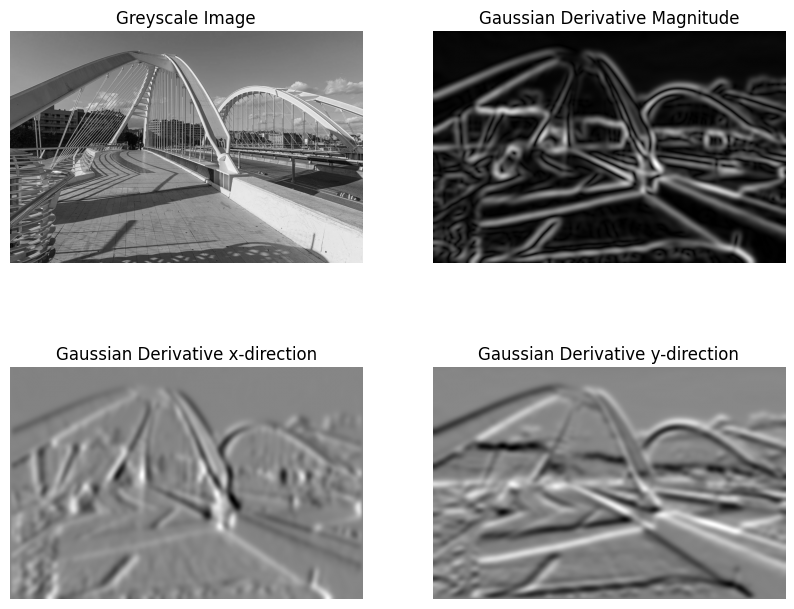

In [21]:
sigma=10
filter_name = 'Gaussian Derivative'
ip_imgs = gaussian_derv_filter(gray,sigma)
plot_img(ip_imgs,filter_name)

# Laplacian Kernel
The lapacian kernel is formed from an approximation to the second order derivative. https://homepages.inf.ed.ac.uk/rbf/HIPR2/log.htm
http://fourier.eng.hmc.edu/e161/lectures/gradient/node7.html
A different test image is used to highlight the black and white lines produced around edges due to filtering with the Laplacian kernel.

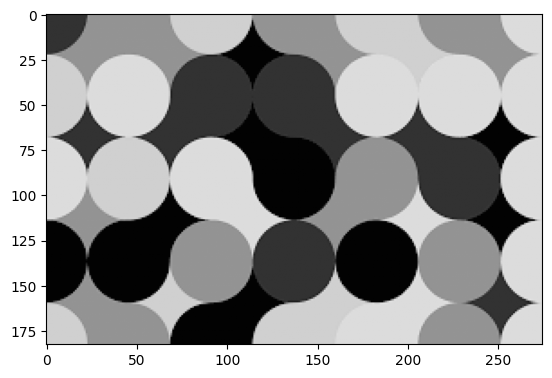

In [18]:
# read in test image
image_url = "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARMAAAC3CAMAAAAGjUrGAAABWVBMVEX/wgDoiAHJPABzAEa/uxH/xAD/xgBwAEf/yADnhQHmgwH/yQC8vhJuAEjIOQDpiQBrAEnrhADvjgDHNABnAEnqjQFkAEnPPwDFKwC+whL+vwDzpQHDwgvBvg66uhL1qgDdlwj4sgDumAHefxDMRgDhkgbkjgTskgHHsg/6uACoTDLUowvYZAC+NhTgdwGrLCbcbQHZnAnPqQ3TWACWIDSxLyGbIzHVdxjLrg6VODrMbx6LLD5+GkLCtxDPvQ64MxvQUACNGjnevgvamSHGgyvDkw3HVwW2cDGuZzTFdwmCKELusBTEZyS1qByFRj2lWzeKUTuBOT+VajSdQTeokCeumyOffy6gJi2CEj/RjyZ5CUOdUTqWRzyNWjmPPT6wVC//yTC0hyRzI0SjhyuadDG1XC3pvwm9oQ/DjgzDTAWyRibGZAfBcArEUxq4oh6zbDKoOSx6MEHXrQBXmdMTAAAbiUlEQVR4nM1d6X/TSNK2LUuyJOuwZdmKD4wT53BiQkKAhBBDIOHKAUw4Y47s7gwwszM7vLv//4e3W5JtHd1SFQu/nfoInXb101XVpe46cgU2OXkELZaLcOpcUxBTK2sdxNzlyxi2lWYuQn8LKPc9MFlCYfIAhwlmbiwmYo5JbEj6KEzyKEz+bmL43kRhsonBWx1gMDG2UJhUEGwX22cYTPKXUZisoWSwh8JkiOK7soLB5B+YqfMOBpPiTgWDSQuDib2OwkS5hjGE9V3M5CgZLBYxmOSXJQwmKEhQAt55VbtAYXINA0l5EcO2gpATYwuJCWIz2x/0vSpm7v+BQfkOqoPazI4u1Lb/Ksozz1Yepu7gTuI8wkPpvNYF+QVGUH6kh6KyPRSWmGwgxYRs5g6Q5/ZYEITaAuoHUCfPCHXysAWFgQnSYfMIKChtIiaCIN/6gYLyHdy272BNKFVgjI8oJERQcMfxCIFJsYjim3kcJw+d4TeICZDx9k+y4FMeAwrqewrrtzFASUCy/02QEIcTAMmZHkAi30ZpD/KjBwOKyjiP45D0v0FxfMYzbwzaP1vChHTU2QPUzAkol1GSkjQpcUhQQh2dPAOUMCSCYP2FQYma133zmyEhky+lQvJLGBICyq0q4rcqP1B9lJ7Ex8T+NvMaohUe553iU12Ikr63gBCVymIRgUr5WgVxJKstSWRjYvfV/0JIAs43mZx32i8FWYiTXLvAiIpyDQPKCKM/yvIgjMrEkNj9Dee/hoTMnl9LoNJpv/opLiSBqIxPqnBYKks7ZTgs5ZVFhKyo880ZKgQOw7CNrfXvgQglRdlcKQe8dzqddnv0+shKCsnEqggXCwQWE2bHKs7aCA5LebSZryhAXBR1vidKokiB6ff7+8N1MxMRRVHUvGkqqpr5K0rFvLy2MyJ0+urns39YbBmZykpt/OLT7raq5AkT2WxUljbXdlaIg3iJUCYq5dG1zctLZFbCdSY4irrc6vaaudzcXHm0s7aULmZ0dK8pSoTEQa/lqGmjTcdZH+43XI/uXr0u8KWEGhVdv/fmxhWbUoHuTqrEkH2ZJ2x7uyl+vn8nA5ZLxfufP0seNXut5VS2ydxOqzegujPBcy3PtUmq020GUkVZEUVp0OKibjrqsGAbxtR0Nxp373FRka23NwqNmXtk2HaKFhP5HpBdCZ8Rn+9wUbl06X7IcFK2c11H5SKSb00XOROza3nmOhWnJ8WdGqJ4HFQcdd+e4TGBxbjORsW6d6URH0ysPQeViB2cssJD5dL9+FDKd89hLzLfFWdYh5WP5enEz+7p9Ln55OymuZVExEPlytukVZGFuwlEAtdRSYKiOAMOJ59ZiNxhXyuKUpcBijofEb6ISVpJMGIOOHfbuVxydkctMBHxUHljJYSEN5bo0Hrce+TtjUcJUbn0mTtYaiZEJe7IxiZbioxXlkU+IzlxEINk3eaukoByI+bbv2ELSSAqMZdajfvfUbofAyVtsCguRxfpxG8g40IXBkXhPYBMZm+GRdzZSIOE0N2w+lhX0yAhoESeIhOfJHFOoqCkbCQlKaL2Ti4+PKGJS2BIKCizydOlxAfFAkpJXFJYlxx8UC5lDc5JIUkxE5AkMRlNh5uZcxP1mRxuppoJSaFxdQKKfj0LEnpVPgFF6WZtDuHkzsyWZA7OiVO8WcEFCUzKk7s77rN7mKRuAIqZuUYKyj1ffeRxNiQElOCblHO7zlkJ6wxOYtJUUyQwgcnk5pt5U8kAZdnXnC3uiROhQHOugAYHDwgKhA/ivgXaAxocHJpsuJOYFIvecBMESaA9ZrYx8ck7fCCaQ8nwHprULkBeKd2Bao4Hioe32mT9HwMS79E126xNJqdG3OnDxKTQeEscWh02loBCMXFgm0O2hwrKHejgnsLVBZacUEEBiokvKGAxIYKiC/JNmJj4cTAKVEw8QbkEZdsTFJX9XyxIiEXhxqswJl/Om0BrQqgBtiYeOdyACAYRizICjxa7Cs94M+VkpcJWNN7kJlhMCoWb+luomNA3Sd7bP3sxoENnQirPPjAxKXNDeFjUVDbAYkIct1qmuzYjY5iH2jVK97PdtRlJyypnkWxMLsNVh04OVx2iPHWE6hT6eQQjuc+wg9gnscXbeDYma5jdEVt9xCobY8Tggo0RWOLMYgb3eBvPxKS4A/Fhp5N3Eeak0ECoDhaTHMac5Jq8E42NyQrcxFLAXczW38UMRmICdNgC4m08GxP4kZZDY4IxJ1hMMGwTQeH8OxuTrBuIKCM4TFCExOT70PeQky4KE8QZhcYEo/JYOVnBTC22MDYWqTt51LmDOS5z4jHGnnS+YM4daR6FyVUUJuslxColjNMrNg9QmDxA+Wx5FCb3MGexMcRgIq5jMDk+RPlsTzBqXBpiTERDQBmUgoZYZW8LgaB0/pgzmonJ3MMNxOQaapFG/QZmuIvQYmnZRbBdenzEwZttY10Dvj3Io/iqBbxl8wlz8JSGLvyyJaeN6xy82ebERkxeAtzYz6hxTxZQBmULvDtizkWYZPG4ZnEMClt1DAOuPCXECskaLUH/QcojLdsFGyxVpce6zFEelpjsEGVweUmVCU5QJ3HjpizIiEslzGms9Q24qolNSxBqm9D72LnfDQQrGvR62iODPvBYqM9A6O4EmwNl+xHhRP7IFBSGmHzxbCZQZktLKDG5LoOfvKYwbsAsiuSNtvMgUMRBjT401Q5g7ztlf+Nhxk1sovy14MVYR92huKDXNy14O4DtpfYxCBJiBU4kNeePYJW2AgBFw1w7Tp4BcVf3ZHsA2iO1Ao/A2AcIinZYCx6u3zEWmYDk16m3AdgfDf6wUwgevAJCYZLtnoqDKSN2tq6VNusTPmqHydFxxXkQcsDcjKiPnJbHuGuTF3T/FR0Dij3MWKbYDFl6V80YLR2HwoPq54nRMSl5EFmk3U3doG+HhIDyFgdKKU19pGbk8MsApXQcia1LghKF5Dy2SHeeP7uoraOc+liUnzzG2BR7K8eX2VLPiFo1dyMFQu2gFmFEqD/SoqPDelP8PbFId0Pi8FIa7CNsSeNuIglB1jPCtyJkFLoae52i5rhxQ2/3BxwJl0qP6zFGBOtjMzJ65pbM/WozFmkXWloSFVGS8glGUhApXI9HPXq8vE2Gx/LJ3Wgydl/Ueqy9MVxVYgRKStrBmBHqLluH4UUGgJTLD/rsbTfcfYJKZHqxJC4V4ELSMG7q7EBqmRU0zCXbVptRTkRJ6w45e2MbTq4UHV3SDj7WmIwI1t55qTSBpXipU54rf3lisIN9PVTsgtolf0HdG5GwIbY2WBIV+yOa7WEYjYZx9V5KFoJsvb16pQHFxXaH802NckL4kEpaz9lPkVbb3WjlyGiPSpp2/Ghc44f+W/rjTUnzULyzs/bkN9fNWKPtuvsLm58/fz6+vN7PHG2Q4f3hxvrGw3/eE+opfHio6Nb43s2rV2/cuAsAxyAzbzitbq87nx/aLn8jJ4zsr+fn51uL54/e1+os/Q2RXq8fPT44btKdLzVbaj/NOthu/8mXYrlM00PK5dGDP1KEio7ecroEcUpkc86fWamJGR4usk7J0t/e5ISbTxe5v6GaNHGGhvuvD/sZoNC/CMi4+2acxohcG389GEy1jcCidTd4qNjuHztz5VDVF6JsDx5yR9vqIKz0RNek8yOOFjPAsYQ3Bg8Wu79hOqFcFpMmgRgIU3+FkwtBfrj+blMrxayyqA2GLHfDcP8YzSXK4HTmvvzGUiBi7sXE4SBSa58htyHS9ZvMFRkFRnYewWiYKSshVAzmASjU3h8zTleKSiuJud3/Mpf8dPaP7qSo2PsDtrMklR4lvIIUVIQbSVGxtzjZTo6CucFpXEkexrJ+wPF9COe5rdjm2793uKWSyivx05v41Fz3UdvknMdMSt5jJzM1QrIyxN0Ix0RFv91M+YQRtWgegfuELSSBqHQeRkenfAgQwAd7CFD06OeQUUjN8wXE+odBiabNWO/4O+lvZ3h29zwNkiK9zA6PbqV/0Ys5DCixb0RGktN3AsV6lnm1EJIUO1VKfP35barK7nzWJYfYhEMiRG6yjQxIAIkyPFD094Cbs9J+sEz7YSYkxeJogom9nj23dIwwtKEIdEiVGgf3QHsvEFl5LyV9bLabg8klXjYi0wvtgrEPub0tHcKPZCLVwTsQrEoNOLzdp+A36segt4+S44mh+wBUnC+4vnVhkR/abYRJEWSffVh9J0gCUYj8TDzrEfCV0XuxMSCa4xFlBfoaJH6D9kDrO5nfoD1j6Hua93jkfgHWcCw/sRGvhto7jKBYBqqYEUp5rhBBsc7BT6ka+dIHi0mx6CLeL8Vj6KePpzzXMWXAkGaWPiLAQzOkvG3DrAmlud9toDXx8D5CWZQGoqgg1qLo+iM4JuToccFSQo+ePjxapXSYXuYiSvoNTGk0BxPjXijINV6QH3Mz+wjVKXZcFYE3UnkMRAU9rJUVEHFhudL6OaJOz9xvsHTKAG+M7gjjBqJUDSLdjNKbZ6iYymXoqUOp/AcmclR7jzp5cMUncQaFF/fIJLGFqTDd+RUzd+kryqD8C1PSyMFAUrjCDLTgYtLLLMsTpi+Y6GUJZ2RxmKCMrIsxsblcE4XJCgqTc8w3j/4Jg4m5jzGymDBTSihMMNlVfyVMoM63T38dOTlB6Q4qQggnJ+IAg0nnTxQmBz8OExOTwIq0J2IPU9q38xplv1FOm4WqcZ5HeffIc6cLrbntYfIBJ4SY64Ja5q1jRHdQmURI/2QeU6+1/W8U4KivwDGqP8D8ABMlhPRjHUyboU4N8X3pBXWDIUGWwm9pCEga98aYPJimiug+0Hll8ZI+2IDHY6dSyEKZWHVQQnzxNFDfxWJLQXR7aH/AfXTnSnDd0VEW1pHEFlx5cPcntDQIQnl0QedlTLExeQRVHn0VpTpdERH9713IwvNgeiqiz1DnF7LCGsYlFJtQ5UE2kRD9fBUY4e5j/VJDYEGhmqB/RV3PAD+NcQXf/YI6JWD+cnBvD2Rb9EtSAduCEGtC2a9jLIoowiyKjnNOvD2XgBbFz4awDmFZHNPafCDN+dP31OXbuKMH4rfVkIeOvysa6OW4MQ5+A7SXQcE1IougDkmTBYBf1HzGH2d/9CA1Z3L/KYoAMzuNc5ePUoPWA0hm9SEBzQdmTUGE+gHm7NE+ZpkU+QgFySwDPZSiwYUkFFfASlaJQdIKVSfOBKX9NGQY6psIUETpdjoo8h6mS0WkXKfUywjxntWdpAL+OCuLoxUprZoOSqcd7W1QP8D4ytLHNPXRjzBdKtRonQKplxr2F4HEC8pJK5IbqzZLQEmxKZ1R/GMukeCQCoqWTAaYUu0FpkOCGn9LkZop+RGNeOij9ZGb8yFKAzNRq1lZ4rTA6LR/TgbtWR85cY9M0g5kTnsE/QRhS1j1ocWSytEfVtyjLrDjHkWpOc8sdM5sgdFpnzLbPci1QwmOiiR+rSVn0WurCFNCKw6yfrDU22Kg0ijcZEYN198N4qjQkvXzvIr4SmUz2pCh02m/esoLSLbkw1jyRAqJpeYjOQKLbMmrC2C9URSzxauhJNLQ8IhdaTSu3NQ5ll2uPzuexlHTqHhxkN7aQKksrq2Uy+12p02o+OpsnBbrqtffHx6XSpKXPZFZM7lUOnh8VLP8ePva3upuZlMR2lzDa7GhLLc45d2niM9vFFyb5ocQbK68eZsWb6/Xjh5tih4sX78+2l3IbOFBmFjf/Xp2dvbh6Z6VGfxr1etvPz1ZbLVa3V5OysBF1DStu/CvG1ev/vPherWa0TGDMKLsnlysrl58PT/WtAw9FUtaqbusbmwM/7V6VK9nuER6vT728jK87RFenJj87SH/dXJLr+m6TCkDDyL944ttb7Np8oSqOqmbKWqD/BbdSirchmH3h2oKKmZ1e3UvECrCdu39YcIMhOeW/NYeZiBZu6tprTss69lBzlefyULkVYVj66sLq9miMaXa7bj0K6rT5aAiaq1hLAeH3xqCIHJyVItwIlv1d8e8NEGx60T7VxBcTvY4TpElHIpTMzj9V91idk0yzVXG2cAjfbzLmkR1mJnK7LPBQ4W1N7t7jG2WyZHB8J9Fqctq/0FgFVj5gLXDUkgNIwvaTohKdZc1B49qqzwNVOcT54Oo8XwIwx4mRMU0X3BuosiCEqIiNuPeZ9o81K0K/3V0TZ9ioFQvMI8x1i7f1SKeVSxhKJEEEkalH7s6MRdY+Z4Ttt/HdFMapHQgqp7E84sfxzCNzR69AK3ewrxjyuk3hdE+fOIg9UIslohhbqfmz+lHkbvPadF9DijbkVXVExULYrNHWhlWb2FCRTIgiTYREAdZOWtGCBRzO+MGV94LqWYGJLHpkpDEMRFqF1NQqi8wUgLoXj2TFDEHuPiZevjmQiYj+u2pRfCu2NOpujsFhXUXllzbpI9uQu/SIQF9tk1+VUuxJTObMjl9zHG2KzBNwwn3NeGDchGgzExVSc4u++bNXEAFbYLaNE9uw0oO5CKZVrf3FvACosL14NF6eneaDkqQDCGzPpcYy/NNShWVQqHDPmX96uki8KnbbyJi7sI2R/a7wWUZE5+CHa8xH3gYk3uWwURpjh4/xLm8UB40YOiMn35QBabM6V89kwLskVhd1bmvDSzAacPl6h4CEkEAf913RUQxRJp/YJ5ALT19jBRbQExMpcatz8acnHwoAwXWJ/0CfC/mSDn44z8VlCo4XIU+iYtQPoiVkgVOPARz8tVq9RbGmiDedcl5LMLjIWyUqR9rXrcUGBEnhVfvkT171UQ5sIju5kqrhCiGaGxUL+B+Y22zxGhayKMqty4oe/KFXVRw4gXikt2BPV4GmGzBVYcqj4bo5Fx9wQslYk9+gtgd+u2HeXgooRI8HYRdk99D/LUJmSe8qBn25Ks4c4J5/1dQJXhtnMDCzQk1KLy4RzYmt44QnAgyLjgRlVDyT4zA1uYxjCzwwjXZk6MgEfYwmCCz9v4PhQkqrknhxVmwJx9jIMEcO9j478ZNlGFDRV0rvFBnzOL/B5gUbqKywjDGPq/wekOwJ0c59vLHHygnKN3ByQm3USZ7lbcxyiM/R2FygqrV/AxlT5ayf39G3C577FW+wFwUyL9gMKmuYlTH/jsKE+gXoLc5Kq+7BnNu/eIFps7Py0UMJkcYTNxTjH+yN8Bgss7r2cKc29r9hNge63QT41Jj+r4Zv81hNueZBLpQCjAZ8vqTMCev5VEXj+1rjObyPE6264gC3faT9nM4KNa5hshGdvZtBCbkcK3Cjax81i7CMamuYvpIul/aP8Mltt6UMAaF2wCDNbd+Yprwj0Drz075MhyTsVfVBEpzxQ6YEfm9Nuu7nUnEJ+CVKGFiYhKjDFaeozZtUArlhHzTcWoXslTnvDwJXgcQLeAPu7WnRPOzbXaQEwsSepNYhZ48+stOsViGOgbedYgMxoSGio2gJw+9DgE8eAWbQy9AOU0TGHPL3gsC0MrK/25TxoGC4l/z6sAGxrZXXQMqKP4DD1RQ/DR+m5ljk5w7CP2fPpWlk3XqVcAoXwYZt8B0w9ogGP0gshCESfCiN+3+ngGJf9nH7g+QmHv6ogd6V9HP2kE0JAiSVd9gwrrNuDt+wZHOS8ju6MGWR6LjeWQqgZ1n9npIQDKevOiZC9kWX/5pAglEe2Yv0JAu8e6vkwDU9lk2J/XpU43EC8cJYzK9/2RpTwLu2bVMZoQDAXAWNVvOdNzC81mZte3tP2bli2KB/SxIQhETopMFijOr9WD0k3GZcUjCX9vVjIcveTwKldMpr6WDEpW7LFDc38MVndrMqG02JOR8zQAlUurB2E8EIEYXKUQv76rbqcHBR8VIhaF0SSFzRf7aSnXx45Vr28/TQInF1Yi5NPUxYxVB7P2mxMfEuh2/gDcX9ri8WB/axSiVV1ixhv5E1U9xmUvpiWe4D+J1v9qvudFburwZPz0kdu6AJySJUs2GEWuVEpra+pSMWjSrF+z69LrwMg4JpctMUTGrC7eTZ4c+ZhduN9yHo2TaQ/v0iLk9cv0dI9VE6iVzTDxOnA1G0BhtJMHARK+9YAcNVxduJQNkdf0XdqHq8spiJc6MWc1fsDeZ1RrCcPsJIfGo0/5ZSKiyXv+4yc4zEVvJ2EfTWWd3wLAL86HECQ9qvTa+UHmhrWSTV4VQJLWsW0eviywhCVDZrMxgoUHd26vc5hCyde9uqPmBYdvu71+SpeOnqLz8KcqI9YyNiI9K11GVECeOucHpCeL1v3BoPok3mWVZ41sX29W0LAS6rotb4xol6x8fXp+2U6u3lcs7a4tO1aOFk9W91OYQsiVcv3rX9ch++ORBkYuIj8ro5w//tigjdeHjo4P0ZCFRanbnfV/fVNaH+6kZcYbtbuVbA4rK6crOfzYXK5m+BQ3iVxcWljbXdkZz6amTnXb71euzp0d7e0KtxkuYCYGiP//l5Z+nK6PiXKTdAgfwzp37n8XB8UDUtFJGZr1IQOm15pfNvLq+sdW308NPveYaTmvQzPkbW7y2CPiI81JalErFWWPYwBkiL5/rXg5HBhi+PZDP/my3O/wq+hG6VLwv+ovNzgyiUtKaKg/RHMdcT5EUw90KWrbMehKVR+wjg0lKZZGbJvg6aQj5iAivO+l6GEXkcxYOIWJkrpmOwmkkYbjD3szIzn6yvLIERyVfucxIEyy2X6aExSfIOgPKhw8JBhExx/RQTFNhZZTa+5HGWOFfzfLOo7Ki7MRB6XSeI14e5PEp9/BiIHIHVfCsx/MeTUYlfFeNmurID5d3EKDkK5tRUDojVPeHpyghuY9AJP2+wFFj2Q9uK+YGR3+6PELce8cysjunMLMaQPIcISQEEpSUpEe1mfmId28n8q3ivz5CSUoIlM4pqt7nD4UkKy8jH5aSZApa/OfL4Ct4D5SQ+iAQmdziQiHB2ZLsNx5TnbX5YFy0JRhAGdp8JbgfDFf9gGCCQIQQAhHYzf20SrPNasOZZKCMeRHPKwEkr1FxIi8R5rV4CVXSFBZJHVwrsdt8MHhAmZSgms4IlRH2FGdMMJBAX0dNwzcmLLwZTJQxYQJ+0TL4Y50nJqcYMcFpDuwpgz5mGNy24iwmUIKSp4ICfqvzxAR55qDEBBxcTut5c6rqsthAPIkTqoyKnTOUmPyJsiYYSHI58Bu6MzQMTqtoJh8od1ZZK7cRiAjCHkZMcMWug9pyEDJV2+YEbzH5KKOUZ2nuFcrCnqHEBPPlhwgroC/GLufCgY0JTnlwqqO/+oEHMSJ2y9na4uRlsDFZQ508O09R5gSBSPEH+GsTMjdUzj0dmxGcQfkPqi3IX8OcUF+WFwvK5gT10ZO/jMpERjlsRdRJDM6Q9EjlxQyzOUF5KIDU+TAmiefDNPpR3gklbg4ChxcUJtsoTM5QmOCOHVT+jsIpBPz/+sCjpRrzZ0cAAAAASUVORK5CYII="
image = url_to_image(image_url)

# Convert to greyscale
HW_trg =256
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray,'gray')

In [19]:
def laplacian_kernel(gray):
   laplace_kernel = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
   lapalce_conv = signal.convolve2d(gray, laplace_kernel, boundary='symm', mode='same')
   lapalce_conv=lapalce_conv.astype(np.float32)
   norm_laplace = norm_img(lapalce_conv)
   laplace_mag = np.sqrt(lapalce_conv**2)
   laplace_mag = norm_img(laplace_mag)
   return [gray,norm_laplace,laplace_mag]

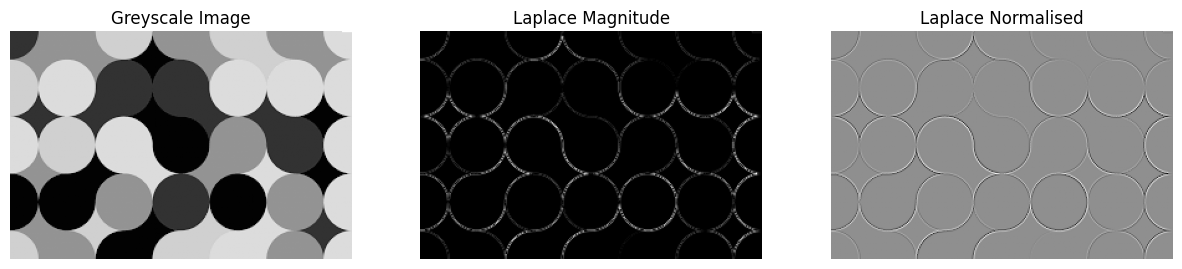

In [20]:
filter_name = 'Laplacian Kernel'
ip_imgs = laplacian_kernel(gray)
labels = ['Laplace Magnitude','Laplace Normalised']
plot_img2(ip_imgs,labels)


#Canny Edge Detection
The OpenCV implementation of the Canny Algorithm is used to find edges in images. A comparison with Sobel Filtering is also shown.  


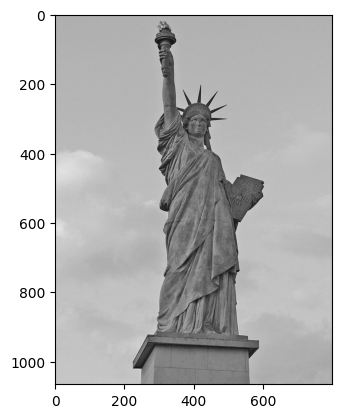

In [21]:
# read in test image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Statue_of_Liberty_Paris_2007-05-29.jpg/800px-Statue_of_Liberty_Paris_2007-05-29.jpg"
image = url_to_image(image_url)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray,'gray')

In [22]:
# Threshold Values for Hystersis Threshold in the Canny Algorithm.
low_threshold = 80
high_threshold = 240
canny_edges = cv2.Canny(gray, low_threshold, high_threshold)

# Compare Sobel
sobel_imgs = sobel_filter(gray)
ip_imgs = [sobel_imgs[0],sobel_imgs[3],canny_edges]

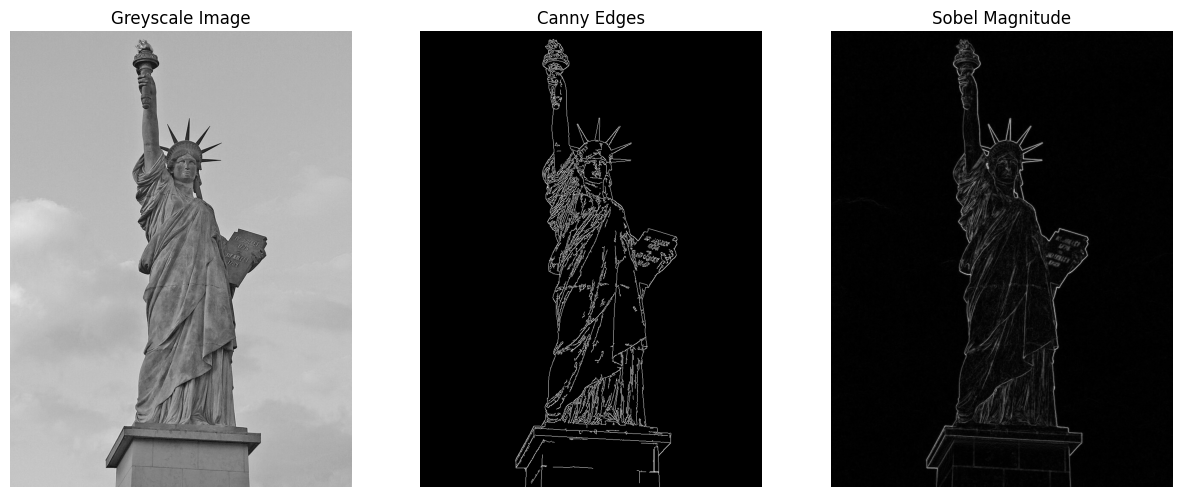

In [23]:
labels = ['Canny Edges','Sobel Magnitude']
plot_img2(ip_imgs,labels)